# Keras Preprocessing

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 11/12/2024   | Martin | Created   | Started Keras Preprcocessing API | 
| 30/12/2024   | Martin | Created   | Completed Keras Preprcocessing API | 

# Content

* [Sequence Preprocessing](#sequence-preprocessing)
* [Text Preprocessing](#text-preprocessing)
* [Image Preprocessing](#image-preprocessing)

# Keras Preprocessing API

For data processing and data augmentation

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator, pad_sequences, skipgrams, make_sampling_table
from tensorflow.keras.preprocessing.text import text_to_word_sequence, hashing_trick, Tokenizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GRU

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["GRPC_VERBOSITY"] = "ERROR"
os.environ["GLOG_minloglevel"] = "2"

## Sequence preprocessing

_Sequence_ data is where older data matter like text or time series data

### Time series generator

`TimeseriesGenerator` takes consecutive data points and applies transformations using time series parameters

In [14]:
series = np.array([i for i in range(10)])
print(f'Original data: {series}')

# predict the next value based on the last 5 lagging observations
generator = TimeseriesGenerator(
  data=series,
  targets=series,
  length=5,
  batch_size=1,
  shuffle=False,
  reverse=False
)
print(f"Samples: {len(generator)}")

for i in range(len(generator)):
  x, y = generator[i]
  print(f"{x} => {y}")

Original data: [0 1 2 3 4 5 6 7 8 9]
Samples: 5
[[0 1 2 3 4]] => [5]
[[1 2 3 4 5]] => [6]
[[2 3 4 5 6]] => [7]
[[3 4 5 6 7]] => [8]
[[4 5 6 7 8]] => [9]


In [18]:
# Define model
model = Sequential()
model.add(Dense(10, activation='relu', input_dim=5))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(
  generator,
  epochs=10
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 60.4673  
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 52.3983 
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 49.2140 
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 51.8469 
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 51.6252 
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 50.5210 
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44.9877 
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 37.1479 
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42.7858 
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 41.5767 


### Padding sequences

Sequence data often have different lengths that need to be processed to fit the same dimensions.
Padding increases the length of shorter sequences to match the larger ones.

For time series data padding is usually done at the beginning of the sequence.

In [3]:
sentences = [["What", "do", "you", "like", "?"],
             ["I", "like", "basket-ball", "!"],
             ["And", "you", "?"],
             ["I", "like", "coconut", "and", "apple"]]

# Build the vocabulary
text_set = set(np.concatenate(sentences))
vocab_to_int = dict(zip(text_set, range(len(text_set))))
int_to_vocab = {vocab_to_int[word]:word for word in vocab_to_int.keys()}

In [4]:
# Encode the sentences
encoded_sentences = []
for sentence in sentences:
  encoded_sentence = [vocab_to_int[word] for word in sentence]
  encoded_sentences.append(encoded_sentence)

# Pad the shorter ones
print(encoded_sentences)
pad_sequences(encoded_sentences)
# maxlen, truncating

[[5, 0, 6, 8, 10], [4, 8, 11, 7], [1, 6, 10], [4, 8, 2, 3, 9]]


array([[ 5,  0,  6,  8, 10],
       [ 0,  4,  8, 11,  7],
       [ 0,  0,  1,  6, 10],
       [ 4,  8,  2,  3,  9]], dtype=int32)

### Skip-grams

Unsupervised learning techniques in NLP - finds the most related words for a given word and predicts the context of the given word.

`skipgrams` in Tensorflow takes in a integer-encoded pair of words and returns their relevance (1 if relevant 0 otherwise). A context word is selected which all examples are compared against, then a window is selected to determine the number of comparisons to perform.

In [5]:
# Encode sentence into integers
sentence = "I like coconut and apple"
encoded_sentence = [vocab_to_int[word] for word in sentence.split()]
vocabulary_size = len(encoded_sentence)

# Setup skipgram
pairs, labels = skipgrams(
  encoded_sentence,
  vocabulary_size,
  window_size=1,
  negative_samples=0
)

# Print the relevancy
for i in range(len(pairs)):
  print(f"({int_to_vocab[pairs[i][0]]} -> {int_to_vocab[pairs[i][0]]}) -> {labels[i]}")

(coconut -> coconut) -> 1
(apple -> apple) -> 1
(and -> and) -> 1
(I -> I) -> 1
(like -> like) -> 1
(and -> and) -> 1
(like -> like) -> 1
(coconut -> coconut) -> 1


---

## Text preprocessing

Need to encode text as numbers and provide integers as inputs

### Split text to word sequence

`text_to_word_sequence` - Transforms a sequence into a list of words/ tokens. Able to set to lowercsae and remove punctuations

In [3]:
sentence = "I like coconut, I like apple"
text_to_word_sequence(sentence, lower=False)

['I', 'like', 'coconut', 'I', 'like', 'apple']

In [4]:
text_to_word_sequence(sentence, lower=True, filters=[])

['i', 'like', 'coconut,', 'i', 'like', 'apple']

### Tokeniser

`Tokenizer` - converts strings/ paragraphs into individual tokens based on the configuration specified

Inputs:

* Max number of words to keep, based on frequency
* List of characters to filter out
* Boolean to convert lower case or not
* Separator for word splitting

In [6]:
sentences = [
  ["What", "do", "you", "like", "?"],
  ["I", "like", "basket-ball", "!"],
  ["And", "you", "?"],
  ["I", "like", "coconut", "and", "apple"]
]

In [7]:
# Create the tokenizer
t = Tokenizer()

# fit tokenizer on documents
t.fit_on_texts(sentences)

In [8]:
# Tokenizer contains useful information in metadata
## Count of each word across all documents
print(t.word_counts)

## Number of documents
print(t.document_count)

## Unique index identifier
print(t.word_index)

## Number of documents (in this case lists) that each word appears in
print(t.word_docs)

OrderedDict([('what', 1), ('do', 1), ('you', 2), ('like', 3), ('?', 2), ('i', 2), ('basket-ball', 1), ('!', 1), ('and', 2), ('coconut', 1), ('apple', 1)])
4
{'like': 1, 'you': 2, '?': 3, 'i': 4, 'and': 5, 'what': 6, 'do': 7, 'basket-ball': 8, '!': 9, 'coconut': 10, 'apple': 11}
defaultdict(<class 'int'>, {'do': 1, 'you': 2, '?': 2, 'like': 3, 'what': 1, '!': 1, 'i': 2, 'basket-ball': 1, 'and': 2, 'coconut': 1, 'apple': 1})


`texts_to_matrix` - provides several bag-of-word methods to compute coefficient of each token

Modes:
* `binary` - whether or not a token is present in the document
* `count` - count of each word in the document
* `tf-idf` - term frequency-inverse document frequency
* `freq` - frequency of the words proportional to the total number of words in the document

In [13]:
print("Binary")
encoded_sentences = t.texts_to_matrix(sentences, mode='binary')
print(encoded_sentences)
print()

print("Word Count")
encoded_sentences = t.texts_to_matrix(sentences, mode='count')
print(encoded_sentences)
print()

print("TF-IDF")
encoded_sentences = t.texts_to_matrix(sentences, mode='tfidf')
print(encoded_sentences)
print()

print("Freq")
encoded_sentences = t.texts_to_matrix(sentences, mode='freq')
print(encoded_sentences)
print()

Binary
[[0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1.]]

Word Count
[[0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1.]]

TF-IDF
[[0.         0.69314718 0.84729786 0.84729786 0.         0.
  1.09861229 1.09861229 0.         0.         0.         0.        ]
 [0.         0.69314718 0.         0.         0.84729786 0.
  0.         0.         1.09861229 1.09861229 0.         0.        ]
 [0.         0.         0.84729786 0.84729786 0.         0.84729786
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.69314718 0.         0.         0.84729786 0.84729786
  0.         0.         0.         0.         1.09861229 1.09861229]]

Freq
[[0.         0.2        0.2        0.2        0.         0.
  0.2        0.2        0.         0.         0.         0. 

---

## Image Preprocessing

`ImageDataGenerator` allows the creation of data from the training dataset i.e expand the number of training data with plausible images

⚠️ _Note: Strategy may differ depending on the task. Some image transformation techniques might not be relevant for the task. e.g predicting handwritten digits v.s predicting baby or not_

In [19]:
# Load CIFAR10 dataset
(x_cifar10_train, y_cifar10_train), (x_cifar10_test, y_cifar10_test) = tf.keras.datasets.cifar10.load_data()

In [21]:
x_cifar10_train = x_cifar10_train[:30000]
x_cifar10_test = x_cifar10_test

y_cifar10_test = y_cifar10_test[:30000]

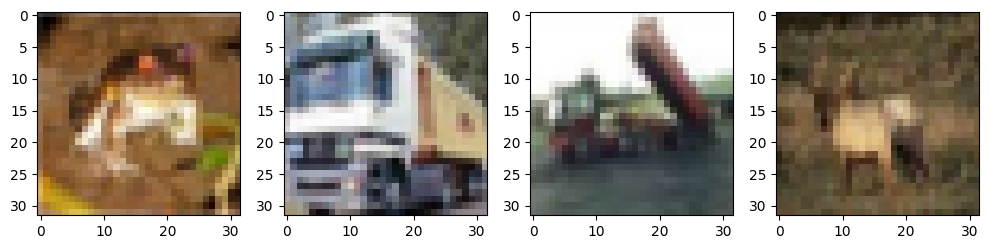

In [30]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
n_cols = 4
for i in range(n_cols):
  plt.subplot(1, n_cols, i+1)
  plt.imshow(x_cifar10_train[i])

plt.tight_layout()
plt.show()

In [35]:
# Create image data generator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True)
## creates additional images that are flipped horizontally

In [36]:
# Iterator that will return one batch of augmented images for each iteration (horizontal flip)
it = datagen.flow(x_cifar10_train[:2], y_cifar10_train[:2], batch_size=1)

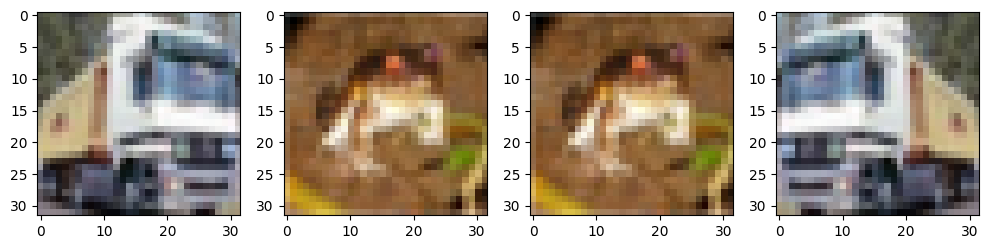

In [37]:
# Display 2 images after transformation and check if the fip is working
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
n_cols = 4
for i in range(n_cols):
  plt.subplot(1, n_cols, i + 1)
  batch = next(it)
  image = tf.squeeze(batch[0])
  plt.imshow(np.uint8(image))
plt.tight_layout()
plt.show()

In [38]:
# Create the actual data generator with more transformations
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
  featurewise_center=True,
  featurewise_std_normalization=True,
  rescale=1./255,
  rotation_range=15,
  width_shift_range=0.3,
  height_shift_range=0.3,
  horizontal_flip=True
)

In [ ]:
# Fit against existing data to get statistics required for normalisation
datagen.fit(x_cifar10_train)

In [ ]:
# Iterator on entire dataset
it = datagen.flow(x_cifar10_train, y_cifar10_train, batch_size=64)

In [41]:
# Define the model
inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(inputs)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=predictions)

In [42]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 591,274 (2.26 MB)

 Trainable params: 591,274 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
  metrics=['accuracy']
)

In [49]:
history = model.fit(
  it,
  epochs=3,
  steps_per_epoch=int(len(x_cifar10_train) / 32),
  validation_data=(x_cifar10_test, y_cifar10_test)
)

Epoch 1/3
  1/937 ━━━━━━━━━━━━━━━━━━━━ 28s 31ms/step - accuracy: 0.0000e+00 - loss: nan

2024-12-30 02:38:07.593103: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-12-30 02:38:07.593171: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 72563476337941632
2024-12-30 02:38:07.593212: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2503367133405533966


937/937 ━━━━━━━━━━━━━━━━━━━━ 1s 731us/step - accuracy: 0.4995 - loss: nan - val_accuracy: 0.1000 - val_loss: nan
Epoch 2/3
  1/937 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 1.0000 - loss: nan

2024-12-30 02:38:08.294671: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 72563476337941632
2024-12-30 02:38:08.294714: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2503367133405533966


937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.5005 - loss: nan - val_accuracy: 0.1000 - val_loss: nan
Epoch 3/3
  1/937 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.0000e+00 - loss: nan

2024-12-30 02:38:08.730883: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 72563476337941632
2024-12-30 02:38:08.730927: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2503367133405533966


937/937 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - accuracy: 0.4995 - loss: nan - val_accuracy: 0.1000 - val_loss: nan


---

# Summary

The Tensorflow Keras Preprocessing API contains a variety of functions to perform data augmentation prior to training the model. These methods are also built into the training mechanism that will automatically apply the transformations to only the training data when necessary.